In [6]:
!pip -q install shap lightgbm catboost


In [7]:
from pathlib import Path
import pandas as pd, numpy as np

DATA = Path("/kaggle/input/house-prices-advanced-regression-techniques")
WORK = Path("/kaggle/working")
FIG  = WORK/"figures"; FIG.mkdir(exist_ok=True)
TAB  = WORK/"tables";  TAB.mkdir(exist_ok=True)

train = pd.read_csv(DATA/"train.csv")
test  = pd.read_csv(DATA/"test.csv")
train.shape, test.shape  # expect (1460, 81) and (1459, 80)


((1460, 81), (1459, 80))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


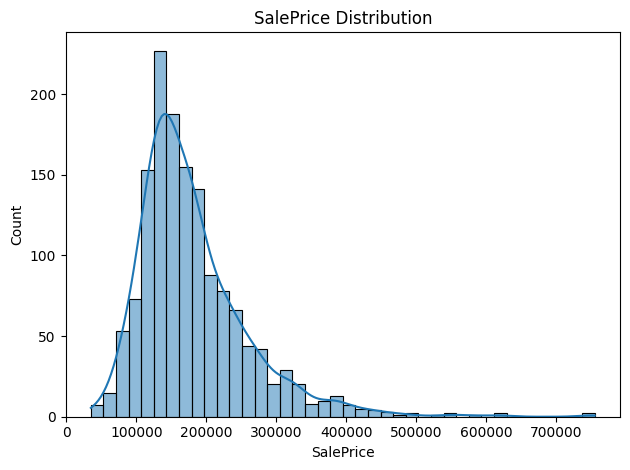

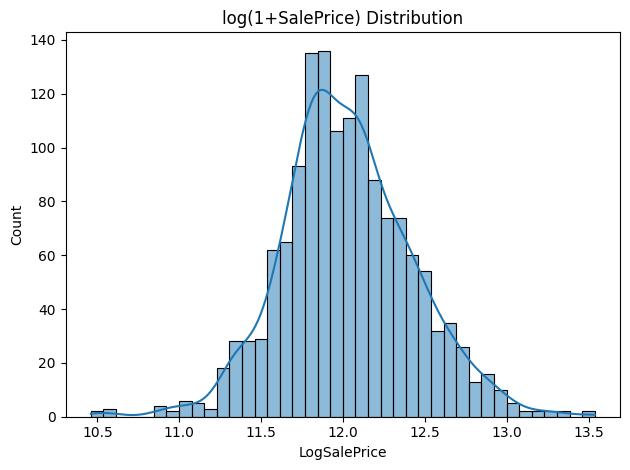

In [8]:
import matplotlib.pyplot as plt, seaborn as sns

train["LogSalePrice"] = np.log1p(train["SalePrice"])

plt.figure(); sns.histplot(train["SalePrice"], bins=40, kde=True)
plt.title("SalePrice Distribution"); plt.tight_layout()
plt.savefig(FIG/"fig1_saleprice_hist.png", dpi=300)

plt.figure(); sns.histplot(train["LogSalePrice"], bins=40, kde=True)
plt.title("log(1+SalePrice) Distribution"); plt.tight_layout()
plt.savefig(FIG/"fig1b_log_saleprice_hist.png", dpi=300)


In [9]:
for df in (train, test):
    df["TotalSF"]    = df[["BsmtFinSF1","BsmtFinSF2","1stFlrSF","2ndFlrSF"]].sum(axis=1)
    df["TotalBaths"] = df["FullBath"] + 0.5*df["HalfBath"] + df.get("BsmtFullBath",0) + 0.5*df.get("BsmtHalfBath",0)
    df["Age"]        = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"]   = df["YrSold"] - df["YearRemodAdd"]
    df["PorchSF"]    = df[["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]].sum(axis=1)
    df["BathsPerBed"]= df["TotalBaths"] / np.clip(df["BedroomAbvGr"], 1, None)
    df["IsRemod"]    = (df["YearRemodAdd"] > df["YearBuilt"]).astype(int)

target_col = "LogSalePrice"
drop_cols  = ["SalePrice","LogSalePrice","Id"]
X = train.drop(columns=[c for c in drop_cols if c in train.columns]); y = train[target_col]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
len(num_cols), len(cat_cols)


(43, 43)

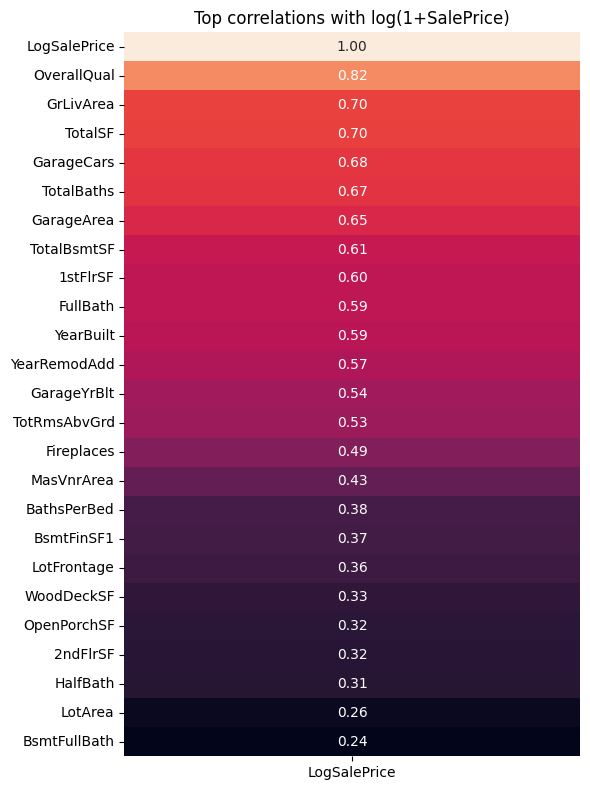

In [10]:
corr = train[num_cols+[target_col]].corr(numeric_only=True)[target_col].sort_values(ascending=False).head(25)
plt.figure(figsize=(6,8))
sns.heatmap(corr.to_frame(), annot=True, fmt=".2f", cbar=False)
plt.title("Top correlations with log(1+SalePrice)")
plt.tight_layout(); plt.savefig(FIG/"fig2_corr_heatmap.png", dpi=300)


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_valid.shape


((1168, 86), (292, 86))

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb, lightgbm as lgb
from catboost import CatBoostRegressor

models = {
    "OLS":  Pipeline([("pre", preprocess), ("mdl", LinearRegression())]),
    "Ridge":Pipeline([("pre", preprocess), ("mdl", Ridge())]),
    "Lasso":Pipeline([("pre", preprocess), ("mdl", Lasso(max_iter=20000))]),
    "Tree": Pipeline([("pre", preprocess), ("mdl", DecisionTreeRegressor(random_state=42))]),
    "RF":   Pipeline([("pre", preprocess), ("mdl", RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1))]),
    "GBM":  Pipeline([("pre", preprocess), ("mdl", GradientBoostingRegressor(random_state=42))]),
    "XGB":  Pipeline([("pre", preprocess), ("mdl", xgb.XGBRegressor(
        n_estimators=1500, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, tree_method="hist"
    ))]),
    "LGBM": Pipeline([("pre", preprocess), ("mdl", lgb.LGBMRegressor(
        n_estimators=2000, learning_rate=0.05, num_leaves=31,
        feature_fraction=0.8, bagging_fraction=0.8, random_state=42, n_jobs=-1
    ))]),
    "CAT":  Pipeline([("pre", preprocess), ("mdl", CatBoostRegressor(
        iterations=2000, learning_rate=0.05, depth=6,
        loss_function="RMSE", random_seed=42, verbose=False
    ))]),
}


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time, pandas as pd

def evaluate(pipe, name):
    t0=time.time(); pipe.fit(X_train,y_train); t=time.time()-t0
    pred = pipe.predict(X_valid)
    return {
        "model": name,
        "rmse_log": mean_squared_error(y_valid, pred, squared=False),
        "mae_log":  mean_absolute_error(y_valid, pred),
        "r2":       r2_score(y_valid, pred),
        "train_sec":t
    }

rows = [evaluate(p, n) for n,p in models.items()]
perf = pd.DataFrame(rows).sort_values("rmse_log").reset_index(drop=True)
perf.to_csv(TAB/"table1_metrics_log.csv", index=False)
perf  # <- this is your Table 1 (log scale)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 185
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, s

,model,rmse_log,mae_log,r2,train_sec
0,CAT,1.274905e-01,0.081333,9.129000e-01,9.556818
1,XGB,1.290177e-01,0.085782,9.108007e-01,2.326391
2,Ridge,1.332684e-01,0.092766,9.048262e-01,0.108645
3,GBM,1.334902e-01,0.092891,9.045093e-01,1.163149
4,LGBM,1.361901e-01,0.087772,9.006074e-01,3.864143
5,RF,1.457369e-01,0.099668,8.861844e-01,7.502900
6,Tree,2.070988e-01,0.143018,7.701640e-01,0.087219
7,Lasso,4.332439e-01,0.337134,-5.837289e-03,0.071080
8,OLS,8.654973e+06,603362.982232,-4.014156e+14,0.113879


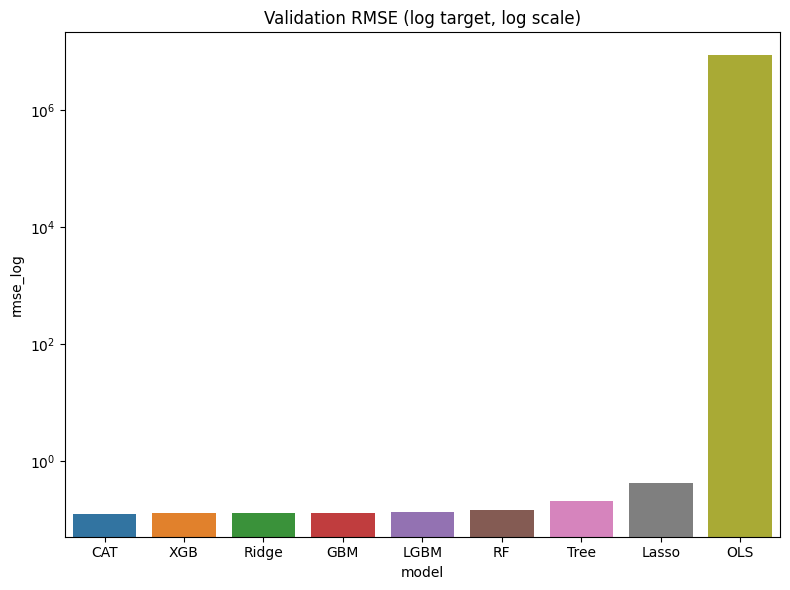

In [23]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=perf, x="model", y="rmse_log")
ax.set_yscale("log")
ax.set_title("Validation RMSE (log target, log scale)")
plt.tight_layout(); plt.savefig(FIG/"fig3_rmse_bar_logscale.png", dpi=300)


'CAT'

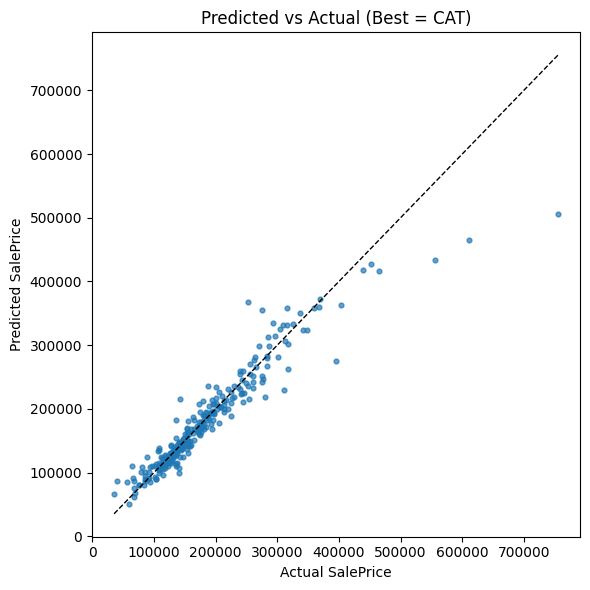

In [15]:
best = perf.iloc[0]["model"]
best_model = models[best].fit(X_train, y_train)
pred_log = best_model.predict(X_valid)

# Back-transform from log to dollars
y_valid_dollars = np.expm1(y_valid)
pred_dollars    = np.expm1(pred_log)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_valid_dollars, pred_dollars, s=12, alpha=0.7)

mn = float(y_valid_dollars.min())
mx = float(y_valid_dollars.max())
plt.plot([mn, mx], [mn, mx], 'k--', lw=1)

plt.title(f"Predicted vs Actual (Best = {best})")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.tight_layout()
plt.savefig(FIG/"fig4_pred_vs_actual.png", dpi=300)

best


The figure layout has changed to tight
The figure layout has changed to tight


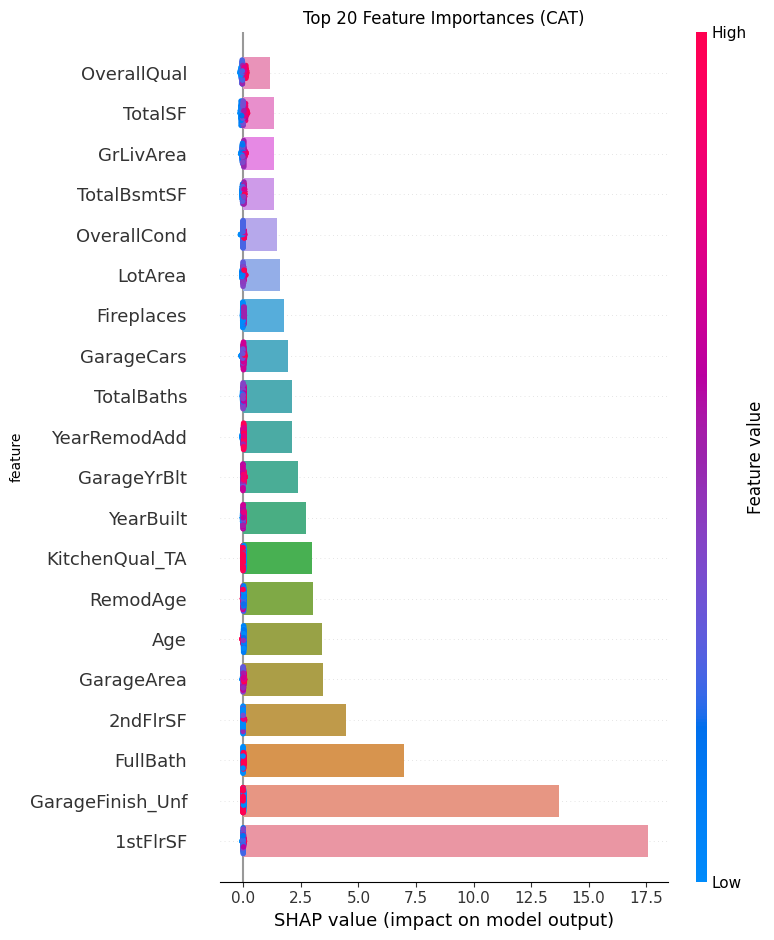

In [16]:
# Build feature names from the fitted preprocessor
pre = best_model.named_steps["pre"]
num_names = pre.named_transformers_["num"].get_feature_names_out(num_cols)
cat_names = pre.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
feature_names = np.r_[num_names, cat_names]

mdl = best_model.named_steps[list(best_model.named_steps.keys())[-1]]

# Figure 5: Top-20 importances (only if model exposes them)
if hasattr(mdl, "feature_importances_"):
    import pandas as pd, seaborn as sns
    imp = mdl.feature_importances_
    top20 = (pd.DataFrame({"feature": feature_names, "importance": imp})
               .sort_values("importance", ascending=False).head(20))
    plt.figure(figsize=(7,6))
    sns.barplot(data=top20, x="importance", y="feature")
    plt.title(f"Top 20 Feature Importances ({best})")
    plt.tight_layout()
    plt.savefig(FIG/"fig5_feature_importance.png", dpi=300)

# Figure 6: SHAP summary (tree models)
try:
    if best in ["RF","GBM","XGB","LGBM","CAT","Tree"]:
        Xv = pre.transform(X_valid)
        import shap
        explainer = shap.TreeExplainer(mdl)
        sv = explainer.shap_values(Xv)
        shap.summary_plot(sv, Xv, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(FIG/"fig6_shap_summary.png", dpi=300)
except Exception as e:
    print("SHAP failed:", e)


In [17]:
row = perf.iloc[0]  # best model row
print(f"{row['model']} attained RMSE (log) = {row['rmse_log']:.4f}, "
      f"MAE (log) = {row['mae_log']:.4f}, R^2 = {row['r2']:.4f} on the validation set.")


CAT attained RMSE (log) = 0.1275, MAE (log) = 0.0813, R^2 = 0.9129 on the validation set.
